In [24]:
from pandas import read_csv
# from numpy import concatenate
import numpy as np
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Bidirectional
# from keras.layers import Reshape
from keras.layers import LSTM
# from keras.layers import TimeDistributed
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# from keras.layers import RepeatVector
from scipy.signal import savgol_filter

In [25]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg  

                      pm1  pm2  pm3   am      sm     st      lum
date                                                            
2022-07-18 15:42:55  3.63  0.0  0.0  3.2  7813.0  25.65  15001.0
2022-07-18 15:47:55  4.19  0.0  0.0  4.8  7692.0  25.66  13863.0
2022-07-18 15:52:55  4.74  0.0  0.0  4.0  7813.0  25.67  13788.0
2022-07-18 15:57:55  5.30  0.0  0.0  4.8  7813.0  25.68  14383.0
2022-07-18 16:02:55  0.55  5.3  5.3  3.2  7813.0  25.69  14621.0


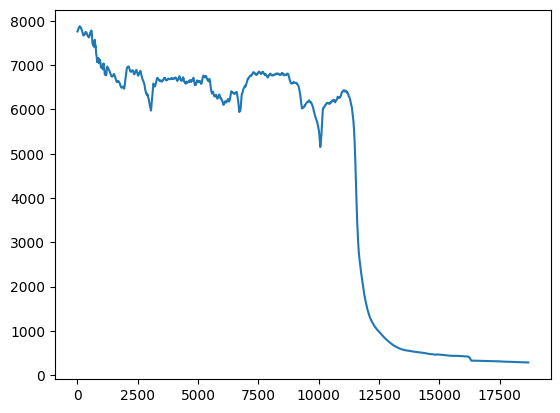

In [26]:
def parse(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

dataset = read_csv('data1.csv',  parse_dates = ['ttime'], index_col=0, date_parser=parse)
dataset.index.name = 'date'
print(dataset.head())
# dataset = read_csv('pollution.csv', header=0, index_col=0)
feature_list = ['sm']
feature_list_len = len(feature_list)
values = dataset[feature_list].values
# print(values[9920:])
# print(values[:9266])
# print(np.delete(values, np.s_[9266:9920], 1)[9300])
values = np.delete(values, np.s_[9266:9920], 0)
# values = values[11000:]
values = savgol_filter(values[:,0], 100, 1).reshape((-1, 1))
plt.plot(values[:, 0])
plt.show()


In [27]:
values = values.astype('float32')
values

array([[7761.4946 ],
       [7762.9717 ],
       [7764.448  ],
       ...,
       [ 288.00015],
       [ 287.98373],
       [ 287.96732]], dtype=float32)

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[9.8517716e-01],
       [9.8537183e-01],
       [9.8556650e-01],
       ...,
       [4.3287873e-06],
       [2.1643937e-06],
       [0.0000000e+00]], dtype=float32)

In [29]:
reframed = series_to_supervised(scaled, 1, 1)
# reframed.drop(reframed.columns[[-1]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)   var1(t)
1   0.985177  0.985372
2   0.985372  0.985566
3   0.985566  0.985761
4   0.985761  0.985956
5   0.985956  0.986151


In [30]:
values = reframed.values
len(values)

18686

In [31]:
train = values[:int(0.85*(len(values))), :]
test = values[int(0.85*(len(values))):, :]

train_X, train_y = train[:, :-feature_list_len], train[:, -feature_list_len:]
test_X, test_y = test[:, :-feature_list_len], test[:, -feature_list_len:]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(15883, 1, 1) (15883, 1) (2803, 1, 1) (2803, 1)


Epoch 1/100
221/221 - 5s - loss: 0.1112 - val_loss: 0.0056 - 5s/epoch - 24ms/step
Epoch 2/100
221/221 - 1s - loss: 0.0752 - val_loss: 0.0086 - 960ms/epoch - 4ms/step
Epoch 3/100
221/221 - 1s - loss: 0.0625 - val_loss: 2.6365e-05 - 949ms/epoch - 4ms/step
Epoch 4/100
221/221 - 1s - loss: 0.0314 - val_loss: 3.5137e-04 - 942ms/epoch - 4ms/step
Epoch 5/100
221/221 - 1s - loss: 0.0108 - val_loss: 2.4701e-05 - 942ms/epoch - 4ms/step
Epoch 6/100
221/221 - 1s - loss: 0.0079 - val_loss: 7.2188e-05 - 950ms/epoch - 4ms/step
Epoch 7/100
221/221 - 1s - loss: 0.0074 - val_loss: 5.8913e-06 - 947ms/epoch - 4ms/step
Epoch 8/100
221/221 - 1s - loss: 0.0071 - val_loss: 4.9239e-05 - 943ms/epoch - 4ms/step
Epoch 9/100
221/221 - 1s - loss: 0.0070 - val_loss: 3.1904e-05 - 945ms/epoch - 4ms/step
Epoch 10/100
221/221 - 1s - loss: 0.0070 - val_loss: 1.0473e-04 - 953ms/epoch - 4ms/step
Epoch 11/100
221/221 - 1s - loss: 0.0069 - val_loss: 3.1870e-06 - 947ms/epoch - 4ms/step
Epoch 12/100
221/221 - 1s - loss: 0.0069

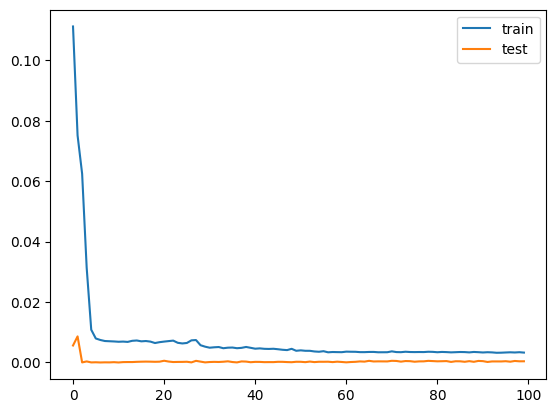

In [32]:
model = Sequential()
# model.add(LSTM(10, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Dropout(0.5))
# # model.add(RepeatVector(1))
# model.add(LSTM(10, activation='relu', return_sequences=True))
# model.add(LSTM(25, activation='relu', return_sequences=True))

model.add(LSTM(units = 64, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))

model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.5))

model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.5))

model.add(LSTM(units = 64))
model.add(Dropout(0.2))


model.add(Dense(feature_list_len))
# model.add(TimeDistributed(Dense(2)))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [33]:
yhat = model.predict(test_X)
yhat = yhat.reshape((-1, feature_list_len))
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat = inv_yhat[:,0]

# # test_y = test_y.reshape((len(test_y), 1))
# # inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(test_y)
inv_y = inv_y[:,0]

88/88 [==============================] - 1s 1ms/step


In [34]:
rmse = mean_squared_error(inv_y, inv_yhat, squared=False)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 151.686


In [35]:
pred = []*len(test_X)
testing = train_X[-1]
testing = testing.reshape((1, 1, feature_list_len))
temp = model.predict(testing, verbose=0)
testing = temp[0].reshape((1, 1, feature_list_len))
for _ in range(len(test_X)):
    # print(testing)
    temp = model.predict(testing, verbose=0)
    pred.append(temp[0])
    testing = pred[-1].reshape((1, 1, feature_list_len))

In [36]:
pred = np.array(pred)
pred = pred.reshape((-1, feature_list_len))
pred = scaler.inverse_transform(pred)
pred = pred[:,0]
rmse = mean_squared_error(inv_y, pred, squared=False)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 175.775
